# Analysis of studio recordings and live performances of songs
#### This notebook contains code to analyze a dataset with musical features of songs, as provided by the spotify API. It also contains labels as to whether a song is recorded at a studio or it is a live performance.

### Let's import the required libraries

In [60]:
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

### Load the dataset

In [83]:
# Load the combined CSV file into a Pandas dataframe
df = pd.read_csv('songs.csv')

### Exploring the data

In [37]:
df.head(10)

,id,energy,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,label
0,7c8McdKXbqVdH1OVlii5dz,0.8480,0.651,7,-10.957,1,0.0334,0.0666,0.000025,0.2860,0.659,109.189,175187,4,studio
1,3whQonlWrOjLVkZcA1GQsV,0.4120,0.696,0,-8.171,0,0.0368,0.5330,0.000000,0.1100,0.499,123.800,180573,4,live
2,7hMhO4oenpVkVaM5bNkEbz,0.4210,0.580,2,-9.161,1,0.0315,0.8670,0.000000,0.2050,0.347,114.725,194680,4,studio
3,0h1HflWtF5FuOhO9qaQobT,0.2640,0.639,7,-18.802,1,0.0425,0.7320,0.755000,0.0522,0.433,125.458,362320,4,studio
4,59OAaOgKSLoNxSrvjYPiYZ,0.8560,0.613,9,-9.729,0,0.0930,0.2250,0.000037,0.1280,0.754,140.552,255040,4,studio
5,5AJT2Tk8mnDEnCtsikWVu2,0.0816,0.513,0,-19.555,1,0.0782,0.9340,0.000132,0.1080,0.129,132.491,276733,4,studio
6,4yWl0tnEanf3zmZzl9kbQn,0.4930,0.488,2,-9.878,1,0.0464,0.2550,0.000181,0.1020,0.389,135.093,296133,4,studio
7,3WKIFsGkI1poPfQ18vY6Ji,0.4140,0.307,1,-9.495,1,0.0384,0.6970,0.000000,0.9700,0.543,84.037,204000,4,live
8,3fALpbGvipaPwK1XFtVDol,0.5850,0.621,3,-6.474,1,0.0246,0.7290,0.000000,0.0768,0.558,96.054,182787,4,studio
9,6efaMrdCksqImu2Bf6FqkX,0.0932,0.647,0,-21.932,0,0.0443,0.8700,0.000015,0.1180,0.443,100.283,172013,4,studio


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                876 non-null    object 
 1   energy            876 non-null    float64
 2   danceability      876 non-null    float64
 3   key               876 non-null    int64  
 4   loudness          876 non-null    float64
 5   mode              876 non-null    int64  
 6   speechiness       876 non-null    float64
 7   acousticness      876 non-null    float64
 8   instrumentalness  876 non-null    float64
 9   liveness          876 non-null    float64
 10  valence           876 non-null    float64
 11  tempo             876 non-null    float64
 12  duration_ms       876 non-null    int64  
 13  time_signature    876 non-null    int64  
 14  label             876 non-null    object 
dtypes: float64(9), int64(4), object(2)
memory usage: 102.8+ KB


In [84]:
# Count the number of samples in each class
class_counts = df['label'].value_counts()

# Print the number of samples in each class
print(class_counts)


label
studio    521
live      355
Name: count, dtype: int64


### Preprocessing

In [85]:
# Drop the columns 'id', 'key', 'mode' and 'signature' as well, because they are irrelevant to this analysis
df = df.drop(['id','mode', 'key', 'time_signature'] , axis=1)
# Select the numerical columns that need to be scaled
num_cols = ['energy', 'danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# Perform standardization on the selected columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Map the labels to integer values
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Create a dictionary mapping integer values to their corresponding labels
label_map = {i: label_encoder.inverse_transform([i])[0] for i in range(len(label_encoder.classes_))}

df.head(10)

,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,label
0,1.088560,1.121665,-0.199991,-0.453493,-1.165971,-0.227897,-0.346135,0.711398,-0.441909,-0.841917,1
1,-0.584754,1.454227,0.448325,-0.384153,0.289248,-0.228109,-0.832687,-0.003380,0.077639,-0.794614,0
2,-0.550214,0.596955,0.217947,-0.492242,1.331365,-0.228109,-0.570060,-0.682419,-0.245056,-0.670717,1
3,-1.152760,1.032981,-2.025563,-0.267905,0.910150,6.263478,-0.992476,-0.298226,0.136596,0.801610,1
4,1.119263,0.840834,0.085771,0.762005,-0.671746,-0.227791,-0.782926,1.135797,0.673319,-0.140595,1
5,-1.852789,0.101806,-2.200790,0.460170,1.540412,-0.226974,-0.838216,-1.656304,0.386680,0.049928,1
6,-0.273886,-0.082951,0.051098,-0.188368,-0.578143,-0.226553,-0.854803,-0.494790,0.479204,0.220311,1
7,-0.577079,-1.420591,0.140224,-0.351522,0.800946,-0.228109,1.544785,0.193184,-1.336282,-0.588862,0
8,0.079198,0.899956,0.843226,-0.632963,0.900790,-0.228109,-0.924469,0.260194,-0.908973,-0.775169,1
9,-1.808270,1.092104,-2.753930,-0.231196,1.340725,-0.227983,-0.810571,-0.253552,-0.758595,-0.869794,1


In [87]:
label_map

{0: 'live', 1: 'studio'}

### Visualizing the data

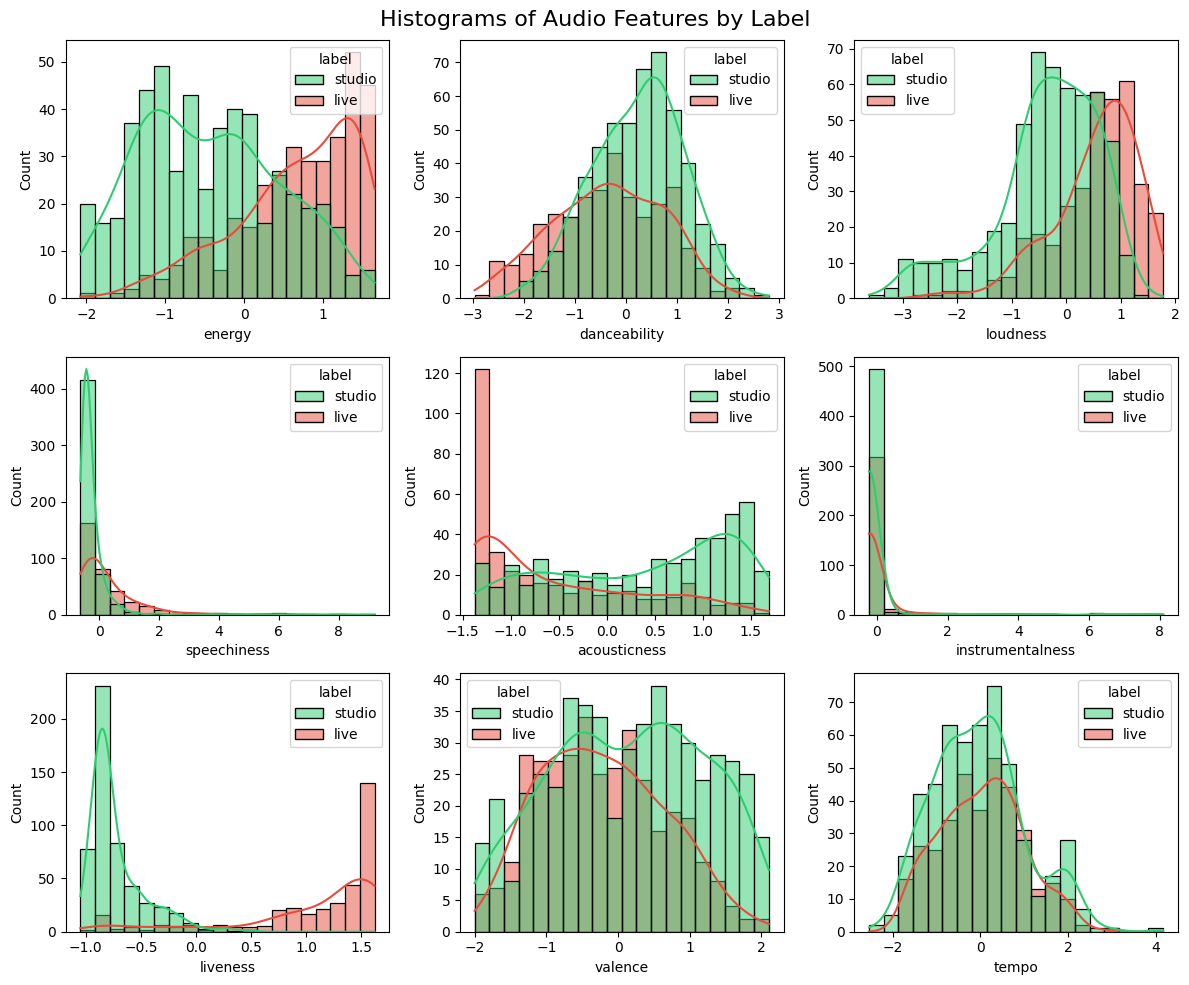

In [89]:
# Define the color palette
colors = ['#2ecc71', '#e74c3c']

nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))
for i, feature in enumerate(df.columns[:-1]):
    row, col = i // 3, i % 3
    if row < nrows and col < ncols:
        ax = axes[row, col]
        sns.histplot(data=df, x=feature, hue=df['label'].map(label_map), ax=ax, kde=True, bins=20, palette=colors)
        ax.set_xlabel(feature)
        


# Add a title to the figure
fig.suptitle("Histograms of Audio Features by Label", fontsize=16)

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the figure
plt.show()

### tSNE vs PCA

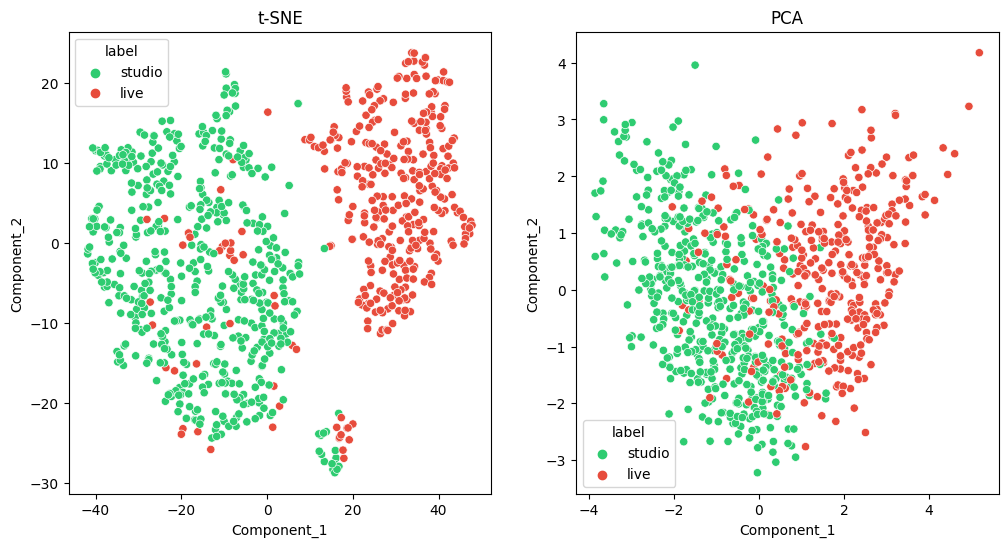

In [91]:
tsne = TSNE(n_components=2, random_state=7)
pca = PCA(n_components=2, random_state=7)

data_tsne = tsne.fit_transform(df)
data_pca = pca.fit_transform(df)

data_tsne_df = pd.DataFrame(data_tsne, columns=['Component_1', 'Component_2'])
data_pca_df = pd.DataFrame(data_pca, columns=['Component_1', 'Component_2'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.scatterplot(data=data_tsne_df, x="Component_1", y="Component_2", hue=df['label'].map(label_map), ax=axes[0], palette=colors)

axes[0].set_title("t-SNE")


sns.scatterplot(data=data_pca_df, x="Component_1", y="Component_2", hue=df['label'].map(label_map), ax=axes[1], palette=colors)

axes[1].set_title("PCA")

plt.show()


In [92]:
# Split the dataframe into a feature matrix (X) and a target vector (y)
X = df.drop('label', axis=1)
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers to train and evaluate
classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('KNN', KNeighborsClassifier())
]

# Train and evaluate each classifier
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, )
    recall = recall_score(y_test, y_pred, )
    f1 = f1_score(y_test, y_pred,)
    
    print(f'{name}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')

    print()

Random Forest:
Accuracy: 0.9432
Precision: 0.9320
Recall: 0.9697
F1 score: 0.9505

SVM:
Accuracy: 0.9432
Precision: 0.9238
Recall: 0.9798
F1 score: 0.9510

Logistic Regression:
Accuracy: 0.9261
Precision: 0.9135
Recall: 0.9596
F1 score: 0.9360

KNN:
Accuracy: 0.9489
Precision: 0.9245
Recall: 0.9899
F1 score: 0.9561



cross-validation and hyperparameter tuning!